In [1]:
! pip install -U accelerate
! pip install -U transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.7 MB/s eta 0:00:00


In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, pipeline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
import openai
import numpy as np
import random
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
# 정상 데이터 0
normal_texts = [
    "부엌에 있는 아이가 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있다.",
    "아이의 어머니는 설거지를 하며 아이가 쿠키를 꺼내는 것을 눈치채지 못하고 있다.",
    "창문 밖에서는 새들이 지저귀고 있다.",
    "아이의 손이 항아리 안으로 들어가 쿠키를 꺼낸다.",
    "아이가 쿠키를 훔치고 있다.",
    "아이의 얼굴에는 장난스러운 미소가 떠올랐다.",
    "어머니는 부엌 싱크대에서 접시를 닦고 있다.",
    "아이의 손에는 초콜릿 칩 쿠키가 쥐어져 있다.",
    "부엌 창문으로 햇살이 들어오고 있다.",
    "아이의 손이 다시 항아리로 향하고 있다.",
    "어머니는 아이가 무슨 일을 하고 있는지 모른다.",
    "아이의 옷에는 초콜릿 부스러기가 묻어 있다.",
    "부엌 싱크대에는 물이 똑똑 떨어지고 있다.",
    "아이의 눈은 쿠키 항아리에 고정되어 있다.",
    "어머니는 창문 밖을 바라보며 잠시 생각에 잠겼다.",
    "부엌 바닥에는 쌀알들이 흩어져 있다.",
    "아이의 손이 항아리에서 두 번째 쿠키를 꺼낸다.",
    "어머니는 설거지에 몰두하고 있다.",
    "아이의 얼굴에는 호기심이 가득하다.",
    "부엌 창문은 활짝 열려 있다.",
    "아이의 손이 쿠키를 움켜쥔다.",
    "부엌 바닥에는 깨진 접시 조각이 있다.",
    "아이의 얼굴에는 만족스러운 표정이 떠올랐다.",
    "부엌 테이블 위에는 사과와 바나나가 놓여 있다.",
    "어머니는 큰 소리로 노래를 부르고 있다.",
    "아이의 손은 쿠키를 향해 점점 더 뻗어 간다.",
    "부엌 바닥에는 깨진 접시 조각이 있다.",
    "창문 밖에서는 새들이 지저귀고 있다.",
    "아이의 눈은 쿠키에 고정되어 있다.",
    "부엌은 따뜻하고 아늑한 분위기다.",
    "아이의 입가에는 쿠키 부스러기가 묻어 있다.",
    "어머니는 설거지에 집중하고 있다.",
    "아이의 발은 의자에 올라가 있다.",
    "부엌 싱크대에는 물이 똑똑 떨어지고 있다.",
    "아이의 손은 쿠키를 움켜쥔다.",
    "어머니는 창문 밖을 바라보고 있다.",
    "부엌 바닥에는 쌀알들이 흩어져 있다.",
    "아이의 티셔츠에는 초콜릿 얼룩이 있다.",
    "부엌 테이블에는 밀가루 자국이 남아 있다.",
    "어머니는 잠시 생각에 잠겨 있다.",
    "아이의 손에는 이미 쿠키가 하나 쥐어져 있다.",
    "부엌 창문 밖에는 나무가 바람에 흔들리고 있다.",
    "아이의 얼굴에는 호기심이 가득하다.",
    "부엌 바닥에는 물자국이 남아 있다.",
    "어머니는 노래를 부르며 웃고 있다.",
    "아이의 손은 또 다른 쿠키를 향해 뻗어 간다.",
    "부엌 싱크대에는 거품이 가득하다.",
    "아이의 눈은 반짝이고 있다.",
    "부엌 창문에는 햇빛이 들어오고 있다.",
    "어머니는 설거지를 멈추고 창밖을 보고 있다.",
    "아이의 손에는 두 개의 쿠키가 있다.",
    "어린아이가 부엌 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있습니다. 아이의 얼굴에는 장난스러운 미소가 떠오르고 있어요.",
    "아이의 어머니는 부엌 싱크대에서 접시를 닦고 있습니다. 아이가 쿠키를 꺼내는 것을 눈치채지 못하고 있는 것 같아요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 꺼내고 있습니다. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문으로 햇살이 들어오고 있고, 새들이 창문 밖에서 지저귀고 있습니다. 아이는 쿠키를 훔치려 하고 있어요.",
    "아이는 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 설거지를 하고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 눈치채지 못하고 접시를 닦고 있어요.",
    "부엌 창문을 통해 햇살이 들어오고 있어요. 아이는 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "어린아이는 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 보이네요.",
    "어머니는 부엌 싱크대에서 설거지를 하고 있습니다. 아이가 쿠키를 꺼내려는 걸 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있어요. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 눈치채지 못하고 설거지를 하고 있어요.",
    "부엌 창문을 통해 햇살이 들어오고 있어요. 아이는 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "어린아이는 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 보이네요.",
    "어머니는 부엌 싱크대에서 설거지를 하고 있습니다. 아이가 쿠키를 꺼내려는 걸 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있어요. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 눈치채지 못하고 설거지를 하고 있어요.",
    "부엌 창문을 통해 햇살이 들어오고 있어요. 아이는 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "어린아이는 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 보이네요.",
    "어머니는 부엌 싱크대에서 설거지를 하고 있습니다. 아이가 쿠키를 꺼내려는 걸 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있어요. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 눈치채지 못하고 설거지를 하고 있어요.",
    "부엌 창문을 통해 햇살이 들어오고 있어요. 아이는 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "어린아이는 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 보이네요.",
    "어머니는 부엌 싱크대에서 설거지를 하고 있습니다. 아이가 쿠키를 꺼내려는 걸 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있어요. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 눈치채지 못하고 설거지를 하고 있어요.",
    "부엌 창문을 통해 햇살이 들어오고 있어요. 아이는 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "어린아이는 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 보이네요.",
    "어머니는 부엌 싱크대에서 설거지를 하고 있습니다. 아이가 쿠키를 꺼내려는 걸 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있어요. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 눈치채지 못하고 설거지를 하고 있어요.",
    "부엌 창문을 통해 햇살이 들어오고 있어요. 아이는 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "어린아이는 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 보이네요.",
    "어머니는 부엌 싱크대에서 설거지를 하고 있습니다. 아이가 쿠키를 꺼내려는 걸 모르고 있어요.",
    "어린아이는 부엌의 작은 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있습니다. 얼굴에는 장난스러운 미소가 떠오르고 있어요.",
    "어머니는 부엌 싱크대에서 접시를 닦고 있습니다. 아이가 몰래 쿠키를 꺼내려는 걸 눈치채지 못하고 있네요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 꺼내고 있습니다. 아이는 매우 신나 보입니다.",
    "부엌 창문으로 햇살이 들어오고 있어요. 창문 밖에서는 새들이 지저귀고 있고, 아이는 쿠키를 훔치려 하고 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 애쓰고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 전혀 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있습니다. 아이는 그걸 먹으려고 하는 것 같아요.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이는 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있어요. 초콜릿 칩 쿠키를 잡으려고 하고 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있습니다. 어머니는 그 상황을 전혀 모르고 있어요.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있습니다. 아이는 매우 신나 보입니다.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키를 꺼내려고 하고 있어요.",
    "어린아이는 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있습니다. 어머니는 그 상황을 모르고 접시를 닦고 있어요.",
    "부엌의 큰 테이블 위에 놓인 쿠키 항아리가 보입니다. 쿠키 항아리 안에는 다양한 모양의 쿠키들이 담겨 있으며, 그 중 몇 개는 초콜릿 칩으로 장식되어 있습니다. 테이블 위에는 쿠키와 함께 우유 한 잔이 놓여 있고, 햇살이 창문을 통해 들어와 부엌을 환하게 비추고 있습니다.",
    "어린아이가 부엌의 작은 의자 위에 올라서서 쿠키 항아리의 뚜껑을 열고 있습니다. 항아리 안에는 맛있어 보이는 초콜릿 칩 쿠키들이 가득 차 있습니다. 아이는 호기심 가득한 표정으로 항아리 안의 쿠키를 바라보며, 손으로 하나를 꺼내려 하고 있습니다.",
    "부엌 싱크대에 있는 어머니가 설거지를 하면서도, 아이가 쿠키 항아리 옆에 서서 쿠키를 꺼내려는 모습을 모르고 있습니다. 쿠키 항아리에는 초콜릿 칩 쿠키와 함께 다양한 쿠키들이 담겨 있으며, 아이는 그 중 하나를 조심스럽게 꺼내고 있습니다.",
    "부엌 창문으로 햇빛이 비추고, 창문 근처의 테이블 위에 놓인 쿠키 항아리가 보입니다. 쿠키 항아리 안에는 초콜릿 칩 쿠키가 가득 차 있으며, 아이는 의자 위에 서서 항아리에서 쿠키를 꺼내려 하고 있습니다. 창문 밖에서는 새들이 지저귀고 있습니다.",
    "부엌 바닥에 떨어진 몇 개의 쿠키 부스러기와 함께, 테이블 위에 놓인 쿠키 항아리가 있습니다. 쿠키 항아리의 뚜껑은 열려 있고, 항아리 안에는 여러 개의 초콜릿 칩 쿠키가 담겨 있습니다. 아이는 항아리에서 쿠키를 꺼내려 하고 있으며, 어머니는 이를 전혀 눈치채지 못하고 있습니다.",
    "어린아이가 부엌 의자 위에 올라가서 쿠키 항아리의 뚜껑을 열고 있습니다. 쿠키 항아리에는 다양한 모양의 쿠키가 담겨 있으며, 아이는 초콜릿 칩 쿠키를 하나 꺼내려고 하고 있습니다. 부엌의 벽에는 쿠키 사진이 장식되어 있어 전체적인 분위기가 따뜻하고 아늑합니다.",
    "부엌의 작은 테이블 위에 놓인 쿠키 항아리에는 여러 개의 초콜릿 칩 쿠키가 담겨 있습니다. 아이는 항아리의 뚜껑을 열고 쿠키를 꺼내려 하고 있으며, 그 모습이 창문을 통해 들어오는 햇살에 비쳐 더욱 선명하게 보입니다. 어머니는 부엌 싱크대에서 설거지를 하고 있어 아이의 행동을 모릅니다."
]

In [5]:
# 비정상 데이터 1
alzheimers_texts = [
    "어제 만난 친구가 생각나.",
    "이 노래 제목이 뭐였더라?",
    "내가 키우던 강아지가 보고 싶네.",
    "점심 먹은 게 뭐였더라?",
    "이번 주말에 여행 갈 계획이 있어.",
    "저녁 메뉴가 뭐였지?",
    "그 영화 정말 재밌었어.",
    "내일은 날씨가 어떨까?",
    "오늘이 무슨 요일이야?",
    "내가 뭘 찾고 있었지?",
    "이걸 어디에 두었지?",
    "그 사람 이름이 뭐였지?",
    "내가 아침에 뭐 했더라?",
    "저녁에 영화 볼래?",
    "어제 본 드라마가 뭐였지?",
    "그 책 정말 재미있었어.",
    "내일 뭐 할까?",
    "이걸 어디에 두었더라?",
    "점심 메뉴가 뭐였지?",
    "그 영화 정말 재밌었어.",
    "오늘이 며칠이야?",
    "그 사람 이름이 기억나지 않아.",
    "저녁에 뭐 먹지?",
    "내가 뭘 하려고 했더라?",
    "내일 약속이 있었나?",
    "오늘 날씨가 어땠지?",
    "그 영화 언제 봤더라?",
    "내일은 무슨 요일이지?",
    "저녁 메뉴가 뭐였지?",
    "내가 뭘 찾고 있었지?",
    "어제 만난 사람이 누구였지?",
    "이걸 어디에 두었지?",
    "배고프다.",
    "오늘이 며칠이야?",
    "저녁에 영화 볼래?",
    "내가 아침에 뭐 했더라?",
    "내일 뭐 할까?",
    "그 영화 정말 재밌었어.",
    "내가 뭘 하려고 했더라?",
    "오늘 날씨가 어땠지?",
    "그 사람 이름이 뭐였지?",
    "저녁 메뉴가 뭐였지?",
    "그 책 정말 재미있었어.",
    "어린아이가 아마도 무언가를 하고 있는 것 같아요. 무슨 일을 하는 건지는 모르겠네요.",
    "아이가... 음, 아마도 뭔가를 먹으려고 하는 것 같아요. 정확히 뭘 하는지는 모르겠어요.",
    "그 그림에서 뭔가를 본 것 같아요. 아, 근데 무슨 일인지 기억이 잘 안 나네요.",
    "아이가 뭔가를 잡으려는 것 같아요. 자세히는 모르겠네요.",
    "저기 아이가 있는 것 같아요. 무슨 일을 하는지는 잘 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 뭔가를 하고 있는 것 같기도 해요.",
    "아이? 아, 무슨 일이 일어나고 있는지 잘 모르겠어요. 쿠키? 아마도?",
    "사진에서 뭔가 중요한 일이 있는 것 같아요. 근데 잘 모르겠어요.",
    "어린 아이가 보이긴 하는데, 정확히 뭘 하는지는 모르겠어요.",
    "사진 속에서 누군가 뭔가를 하고 있는 것 같아요. 아마도 아이가 무언가를...?",
    "아이가 사진에 있는데... 뭐하고 있는지는 잘 모르겠어요. 쿠키가 있나요?",
    "아이의 행동이 뭔가 중요한 것 같은데, 정확히는 모르겠어요.",
    "아마도 쿠키? 아이가 뭔가를 하고 있는 것 같긴 해요.",
    "사진에 뭔가 중요한 일이 있는 것 같은데, 잘 모르겠어요.",
    "아이와 뭔가가 있는 것 같은데, 잘 모르겠어요.",
    "아이? 아마도 쿠키? 사진 속에 뭔가가 있긴 한데, 정확히는 모르겠어요.",
    "어린아이가 뭔가를 잡으려고 하는 것 같아요. 근데 잘 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는지 정확히 모르겠어요. 아이가 뭔가를 하고 있는 것 같아요.",
    "아이의 행동이 중요한 것 같은데, 잘 모르겠어요.",
    "아이가 사진 속에 있고, 뭔가를 잡으려고 하는 것 같아요. 자세히는 모르겠어요.",
    "사진 속에서 뭔가가 일어나고 있는 것 같아요. 아이가 있나요?",
    "아이의 행동을 잘 모르겠어요. 사진 속에서 무슨 일이 일어나고 있는 것 같아요.",
    "사진 속에서 뭔가를 잡으려고 하는 아이가 있는 것 같아요. 근데 잘 모르겠어요.",
    "아이의 행동을 잘 이해하지 못하겠어요. 사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요.",
    "아이? 사진 속에 뭔가가 일어나고 있는 것 같아요. 쿠키가 있나요?",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 잘 모르겠어요.",
    "사진 속에서 뭔가가 일어나고 있는 것 같아요. 아이가 보이나요?",
    "사진 속에 아이가 있는 것 같은데, 잘 모르겠어요.",
    "아이가 뭔가를 하고 있는 것 같아요. 사진 속에서 무슨 일이 일어나고 있는지 정확히 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 보이긴 하는데...",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 자세히는 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 있나요?",
    "아이가 뭔가를 하고 있는 것 같아요. 정확히 뭘 하는지는 잘 모르겠어요.",
    "사진 속에 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 보이는 것 같아요.",
    "아이의 행동을 잘 모르겠어요. 사진 속에서 무슨 일이 일어나고 있는 것 같아요.",
    "사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이의 행동을 잘 이해하지 못하겠어요. 사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요.",
    "아이? 사진 속에 뭔가가 일어나고 있는 것 같아요. 쿠키가 있나요?",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 잘 모르겠어요.",
    "사진 속에서 뭔가가 일어나고 있는 것 같아요. 아이가 보이나요?",
    "사진 속에 아이가 있는 것 같은데, 잘 모르겠어요.",
    "아이가 뭔가를 하고 있는 것 같아요. 사진 속에서 무슨 일이 일어나고 있는지 정확히 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 보이긴 하는데...",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 자세히는 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 있나요?",
    "아이가 뭔가를 하고 있는 것 같아요. 정확히 뭘 하는지는 잘 모르겠어요.",
    "사진 속에 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 보이는 것 같아요.",
    "아이의 행동을 잘 모르겠어요. 사진 속에서 무슨 일이 일어나고 있는 것 같아요.",
    "사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이의 행동을 잘 이해하지 못하겠어요. 사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요.",
    "아이? 사진 속에 뭔가가 일어나고 있는 것 같아요. 쿠키가 있나요?",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 잘 모르겠어요.",
    "사진 속에서 뭔가가 일어나고 있는 것 같아요. 아이가 보이나요?",
    "사진 속에 아이가 있는 것 같은데, 잘 모르겠어요.",
    "아이가 뭔가를 하고 있는 것 같아요. 사진 속에서 무슨 일이 일어나고 있는지 정확히 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 보이긴 하는데...",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 자세히는 모르겠어요.",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 있나요?",
    "아이가 뭔가를 하고 있는 것 같아요. 정확히 뭘 하는지는 잘 모르겠어요.",
    "사진 속에 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 보이는 것 같아요.",
    "아이의 행동을 잘 모르겠어요. 사진 속에서 무슨 일이 일어나고 있는 것 같아요.",
    "사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이의 행동을 잘 이해하지 못하겠어요. 사진 속에서 무슨 일이 일어나고 있는지 잘 모르겠어요.",
    "아이? 사진 속에 뭔가가 일어나고 있는 것 같아요. 쿠키가 있나요?",
    "사진 속에서 무슨 일이 일어나고 있는 것 같아요. 아이가 뭔가를 잡으려고 하는 것 같아요.",
    "아이가 뭔가를 잡으려고 하는 것 같은데, 잘 모르겠어요.",
    "사진 속에서 뭔가가 일어나고 있는 것 같아요. 아이가 보이나요?",
    "사진 속에 아이가 있는 것 같은데, 잘 모르겠어요.",
    "쿠키를 잡기위해서 노력하는 모습인가요?."
]

In [6]:
#gpt 정상 데이터 0
normal_texts_gpt =[
"상황을 명확하게 묘사하고 있습니다. 이 반응은 10점 중 9점으로 평가할 수 있습니다. 발음도 명확합니다.",
    "상황을 명확하게 묘사하고 있으며, 아이와 어머니의 행동을 잘 설명하고 있습니다. 10점 중 9점입니다. 명확성과 유창성이 뛰어납니다.",
    "사진의 배경을 설명하고 있지만, 핵심 요소인 아이와 쿠키를 언급하지 않아 10점 중 5점입니다. 유창성은 있으나 명확성이 부족합니다.",
    "상황을 구체적으로 묘사하고 있어 10점 중 8점입니다. 명확성과 유창성이 뛰어납니다.",
    "상황을 명확하게 묘사하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다. 발음도 명확합니다.",
    "아이의 표정을 구체적으로 묘사하여 상황을 생생하게 전달하고 있습니다. 10점 중 8점입니다. 명확성과 유창성이 뛰어납니다.",
    "상황을 명확하게 묘사하고 있으며, 어머니의 행동을 잘 설명하고 있습니다. 10점 중 8점입니다. 명확성과 유창성이 뛰어납니다.",
    "아이의 손에 쿠키가 있는 상황을 잘 묘사하고 있습니다. 10점 중 8점입니다. 명확성과 유창성이 뛰어납니다.",
    "부엌의 환경을 묘사하고 있지만, 핵심 요소인 아이와 쿠키를 언급하지 않아 10점 중 5점입니다. 유창성은 있으나 명확성이 부족합니다.",
    "아이의 행동을 구체적으로 묘사하고 있어 10점 중 8점입니다. 명확성과 유창성이 뛰어납니다.",
    "상황을 명확하게 묘사하고 있으며, 어머니의 행동을 잘 설명하고 있습니다. 10점 중 8점입니다. 명확성과 유창성이 뛰어납니다.",
"아이의 옷에는 초콜릿 부스러기가 묻어 있다. 상황을 명확하게 묘사하고 있으며, 불필요한 반복이나 주저함 없이 정확히 표현하고 있다. 10점 중 9점으로 평가할 수 있다. 발음도 명확하고 클리어하게 전달되었다.",
    "부엌 싱크대에는 물이 똑똑 떨어지고 있다. 사진의 중요한 요소는 아니지만 부엌의 세부적인 부분을 잘 관찰하고 있다. 10점 중 7점으로 평가할 수 있다. 발음도 명확하다.",
    "아이의 눈은 쿠키 항아리에 고정되어 있다. 중요한 포인트를 명확하게 묘사하고 있다. 10점 중 8점으로 평가할 수 있다. 클리어하고 일관된 설명이다.",
    "어머니는 창문 밖을 바라보며 잠시 생각에 잠겼다. 사진의 핵심 요소는 아니지만 배경을 잘 설명하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "부엌 바닥에는 쌀알들이 흩어져 있다. 사진의 주요 내용은 아니지만 주변 상황을 잘 관찰하고 있다. 10점 중 6점으로 평가할 수 있다. 설명은 명확하다.",
    "아이의 손이 항아리에서 두 번째 쿠키를 꺼낸다. 사진의 핵심 요소를 잘 설명하고 있으며, 클리어한 설명이다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "어머니는 설거지에 몰두하고 있다. 사진의 배경을 잘 설명하고 있으며, 중요한 요소 중 하나를 잘 포착했다. 10점 중 7점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 얼굴에는 호기심이 가득하다. 아이의 표정을 잘 묘사하고 있으며, 상황을 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 창문은 활짝 열려 있다. 사진의 배경을 잘 설명하고 있지만, 핵심 요소는 아니다. 10점 중 6점으로 평가할 수 있다. 설명은 명확하다.",
    "아이의 손이 쿠키를 움켜쥔다. 중요한 포인트를 잘 설명하고 있으며, 클리어한 설명이다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 바닥에는 깨진 접시 조각이 있다. 사진의 주요 내용은 아니지만 주변 상황을 잘 설명하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 얼굴에는 만족스러운 표정이 떠올랐다. 아이의 감정을 잘 묘사하고 있으며, 상황을 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 테이블 위에는 사과와 바나나가 놓여 있다. 사진의 핵심 요소는 아니지만 배경을 잘 설명하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
"어머니는 큰 소리로 노래를 부르고 있다. 사진의 주요 요소는 아니지만 배경을 잘 설명하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 손은 쿠키를 향해 점점 더 뻗어 간다. 중요한 상황을 잘 묘사하고 있으며, 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 바닥에는 깨진 접시 조각이 있다. 사진의 주요 내용은 아니지만 주변 상황을 잘 관찰하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "창문 밖에서는 새들이 지저귀고 있다. 사진의 배경을 잘 설명하고 있으며, 세부적인 부분을 잘 관찰하고 있다. 10점 중 7점으로 평가할 수 있다. 발음도 명확하다.",
    "아이의 눈은 쿠키에 고정되어 있다. 중요한 포인트를 잘 묘사하고 있으며, 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌은 따뜻하고 아늑한 분위기다. 사진의 주요 요소는 아니지만 전체적인 분위기를 잘 설명하고 있다. 10점 중 7점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 입가에는 쿠키 부스러기가 묻어 있다. 아이의 행동을 잘 관찰하고 있으며, 상황을 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "어머니는 설거지에 집중하고 있다. 사진의 배경을 잘 설명하고 있으며, 중요한 요소 중 하나를 잘 포착했다. 10점 중 7점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 발은 의자에 올라가 있다. 중요한 상황을 잘 묘사하고 있으며, 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 싱크대에는 물이 똑똑 떨어지고 있다. 사진의 주요 내용은 아니지만 주변 상황을 잘 관찰하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 손은 쿠키를 움켜쥔다. 중요한 포인트를 잘 설명하고 있으며, 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "어머니는 창문 밖을 바라보고 있다. 사진의 배경을 잘 설명하고 있으며, 세부적인 부분을 잘 관찰하고 있다. 10점 중 7점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 바닥에는 쌀알들이 흩어져 있다. 사진의 주요 내용은 아니지만 주변 상황을 잘 관찰하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "아이의 티셔츠에는 초콜릿 얼룩이 있다. 아이의 행동을 잘 관찰하고 있으며, 상황을 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 테이블에는 밀가루 자국이 남아 있다. 사진의 주요 내용은 아니지만 주변 상황을 잘 관찰하고 있다. 10점 중 6점으로 평가할 수 있다. 발음은 명확하다.",
    "어머니는 잠시 생각에 잠겨 있다. 사진의 배경을 잘 설명하고 있으며, 세부적인 부분을 잘 관찰하고 있다. 10점 중 7점으로 평가할 수 있다. 발음도 명확하다.",
    "아이의 손에는 이미 쿠키가 하나 쥐어져 있다. 중요한 포인트를 잘 설명하고 있으며, 명확하게 설명하고 있다. 10점 중 8점으로 평가할 수 있다. 발음도 명확하다.",
    "부엌 창문 밖에는 나무가 바람에 흔들리고 있다. 사진의 배경을 잘 설명하고 있으며, 세부적인 부분을 잘 관찰하고 있다. 10점 중 7점으로 평가할 수 있다. 발음도 명확하다.",
"이 설명은 아이의 얼굴에 호기심이 가득하다는 점을 잘 표현하고 있으며, 상황을 이해하는 데 도움이 됩니다. 그러나 어머니의 행동이나 배경 요소들에 대한 언급이 부족합니다. 전반적으로 설명은 명확하지만, 상황의 전체적인 맥락을 포괄하지는 못합니다. 이 반응은 10점 중 6점으로 평가할 수 있습니다.",
"부엌 바닥의 물자국은 상황의 일부를 잘 반영하고 있으나, 주요 요소인 아이의 행동이나 어머니의 반응에 대한 설명이 부족합니다. 설명이 불완전하여 전체적인 맥락을 이해하는 데 어려움이 있습니다. 이 반응은 10점 중 5점으로 평가할 수 있습니다.",
"어머니가 노래를 부르며 웃고 있다는 설명은 부적절하며, 현재의 상황과 맞지 않습니다. 사진의 주요 요소를 제대로 반영하지 못하고 있어, 이 반응은 10점 중 2점으로 평가할 수 있습니다.",
"아이의 손이 또 다른 쿠키를 향해 뻗어 간다는 설명은 주요 행동을 잘 묘사하고 있지만, 전체적인 배경이나 어머니의 행동에 대한 설명이 부족합니다. 이 반응은 10점 중 6점으로 평가할 수 있습니다.",
"부엌 싱크대에 거품이 가득하다는 설명은 배경을 잘 반영하고 있지만, 아이의 행동이나 어머니의 반응과 같은 주요 요소가 누락되어 있습니다. 이 반응은 10점 중 5점으로 평가할 수 있습니다.",
"아이의 눈이 반짝이고 있다는 묘사는 아이의 감정을 잘 표현하고 있지만, 다른 주요 요소들에 대한 설명이 부족합니다. 설명이 부분적이며, 전체 상황을 이해하는 데 한계가 있습니다. 이 반응은 10점 중 5점으로 평가할 수 있습니다.",
"부엌 창문에 햇빛이 들어오고 있다는 설명은 배경 요소를 잘 설명하지만, 아이의 행동이나 어머니의 반응에 대한 설명이 부족합니다. 이 반응은 10점 중 4점으로 평가할 수 있습니다.",
"어머니가 설거지를 멈추고 창밖을 보고 있다는 설명은 적절하지만, 아이의 행동에 대한 언급이 부족합니다. 전체적인 맥락을 이해하기 어려운 부분이 있습니다. 이 반응은 10점 중 6점으로 평가할 수 있습니다.",
"아이의 손에 두 개의 쿠키가 있다는 설명은 구체적이지만, 상황의 전체적인 설명이나 다른 중요한 요소들에 대한 설명이 부족합니다. 이 반응은 10점 중 5점으로 평가할 수 있습니다.",
"어린아이가 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있으며, 얼굴에는 장난스러운 미소가 있다는 설명은 상황을 잘 포착하고 있습니다. 설명이 명확하고 일관성이 있으며, 주요 요소를 잘 포함하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
"아이의 어머니가 부엌 싱크대에서 접시를 닦고 있으며, 아이가 쿠키를 꺼내는 것을 눈치채지 못하고 있다는 설명은 상황을 잘 설명하고 있습니다. 주요 요소가 잘 포함되어 있으며, 설명이 명확합니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
"아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 꺼내고 있는 장면과 아이가 그것을 먹으려고 하는 모습이 잘 설명되어 있습니다. 주요 요소가 잘 반영되어 있으며, 설명이 일관되고 명확합니다. 이 반응은 10점 중 9점으로 평가할 수 있습니다.",
"부엌 창문으로 햇살이 들어오고 새들이 지저귀고 있다는 설명은 배경을 잘 반영하고 있지만, 아이의 행동에 대한 설명이 부족합니다. 전반적으로 설명이 불완전하여, 이 반응은 10점 중 5점으로 평가할 수 있습니다.",
"아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있으며, 어머니가 그 상황을 모르고 설거지를 하고 있다는 설명은 상황을 잘 묘사하고 있습니다. 설명이 구체적이며 상황을 명확히 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
"이 설명은 아이의 손이 쿠키 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 행동을 잘 표현하고 있습니다. 그러나 아이의 감정이나 어머니의 반응에 대한 정보는 부족합니다. 설명은 명확하나 상황의 전체적인 이해를 위해 추가적인 정보가 필요합니다. 이 반응은 10점 중 7점으로 평가할 수 있습니다.",
    "아이의 행동과 어머니의 반응을 잘 설명하고 있으며, 상황을 명확하게 반영하고 있습니다. 주요 요소가 잘 포함되어 있으며, 전반적으로 일관된 설명을 제공합니다. 이 반응은 10점 중 9점으로 평가할 수 있습니다.",
    "부엌 창문으로 햇살이 들어오고 아이가 쿠키를 꺼내려고 하는 장면을 잘 묘사하고 있습니다. 설명이 명확하며, 상황의 핵심 요소를 포함하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 장난스러운 미소와 의자 위에서 쿠키 항아리에 손을 뻗고 있는 행동이 잘 묘사되고 있습니다. 설명이 명확하고 구체적이며, 주요 요소를 잘 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어머니가 설거지를 하면서 아이가 쿠키를 꺼내려는 상황을 인식하지 못하는 점을 잘 설명하고 있습니다. 주요 요소가 잘 포함되어 있으며, 상황을 명확히 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면이 잘 설명되어 있습니다. 아이의 의도와 행동을 명확히 나타내고 있으며, 설명이 일관됩니다. 이 반응은 10점 중 9점으로 평가할 수 있습니다.",
    "부엌 창문을 통한 햇살과 새들의 지저귐을 포함한 배경 설명과 아이의 행동이 잘 조화되어 있습니다. 설명이 명확하며 주요 요소를 잘 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에서 쿠키 항아리에 손을 뻗는 장면을 잘 설명하고 있으며, 어머니가 그 상황을 모르고 있는 점도 포함되어 있습니다. 설명이 구체적이며 일관된 맥락을 제공합니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면이 잘 설명되어 있습니다. 설명이 명확하나, 배경이나 다른 요소들에 대한 정보가 부족합니다. 이 반응은 10점 중 7점으로 평가할 수 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내는 장면과 어머니의 반응을 잘 설명하고 있습니다. 설명이 일관되고 주요 요소를 잘 포함하고 있습니다. 이 반응은 10점 중 9점으로 평가할 수 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 아이가 쿠키를 꺼내려고 하는 장면을 잘 묘사하고 있습니다. 설명이 명확하며 상황의 주요 요소를 포함하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에 올라가서 쿠키 항아리에 손을 뻗는 행동과 장난스러운 미소를 잘 설명하고 있습니다. 설명이 구체적이며 주요 요소를 잘 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어머니가 부엌 싱크대에서 설거지를 하면서 아이가 쿠키를 꺼내려는 상황을 인식하지 못하는 점을 잘 설명하고 있습니다. 설명이 명확하고 일관되며, 주요 요소가 포함되어 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "이 설명은 아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있는 장면을 잘 설명하고 있습니다. 아이의 의도도 명확히 언급되어 있으며, 설명이 일관됩니다. 그러나 어머니의 반응에 대한 정보가 부족하여 상황의 전반적인 이해를 위해 추가적인 세부사항이 필요합니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 창문 밖에서 새들이 지저귀고 있는 배경과 아이의 행동이 잘 묘사되어 있습니다. 설명이 명확하고 주요 요소가 포함되어 있으며, 상황을 잘 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있는 장면과 어머니가 그 상황을 모르는 점이 잘 설명되어 있습니다. 설명이 명확하고, 주요 요소가 포함되어 있으나 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면을 명확히 설명하고 있습니다. 그러나 어머니의 반응이나 상황의 맥락에 대한 정보는 부족합니다. 설명이 일관되지만 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이와 어머니의 행동을 잘 설명하고 있으며, 어머니가 상황을 인식하지 못하는 점도 잘 반영하고 있습니다. 설명이 일관되며, 주요 요소가 잘 포함되어 있습니다. 다만, 설명이 약간 반복적입니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통한 햇살과 아이의 행동이 잘 설명되어 있으며, 주요 요소가 포함되어 있습니다. 설명이 명확하나 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에서 쿠키 항아리에 손을 뻗는 장면과 장난스러운 미소를 잘 설명하고 있습니다. 설명이 구체적이며 주요 요소를 잘 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어머니가 설거지를 하면서 아이가 쿠키를 꺼내려는 상황을 인식하지 못하는 점을 잘 설명하고 있습니다. 설명이 일관되며, 주요 요소가 포함되어 있습니다. 다만, 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면이 잘 설명되어 있습니다. 설명이 명확하고 일관되며 주요 요소를 잘 반영하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통한 햇살과 아이의 행동을 잘 묘사하고 있습니다. 설명이 명확하며 주요 요소가 포함되어 있습니다. 그러나 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "이 설명은 어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있는 장면과 어머니가 그 상황을 모르는 점을 잘 설명하고 있습니다. 주요 요소가 잘 포함되어 있으며, 설명이 명확하고 일관됩니다. 다만, 약간의 반복이 있어 주의가 필요합니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면을 명확히 설명하고 있습니다. 설명이 일관되며 주요 요소가 포함되어 있으나, 상황의 전반적인 맥락을 더 추가할 수 있으면 좋겠습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있으며, 어머니가 그 상황을 모른 채 설거지를 하고 있는 장면을 잘 설명하고 있습니다. 설명이 명확하며 주요 요소가 잘 반영되어 있습니다. 다만, 반복적인 부분이 있으며 약간의 수정이 필요할 수 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 아이가 쿠키 항아리에서 쿠키를 꺼내려고 하는 장면을 잘 묘사하고 있습니다. 설명이 명확하고 주요 요소가 포함되어 있으나, 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있는 장면과 장난스러운 미소를 잘 설명하고 있습니다. 설명이 구체적이며 주요 요소를 잘 반영하고 있습니다. 그러나 일부 설명이 반복적일 수 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어머니가 부엌 싱크대에서 설거지를 하며 아이가 쿠키를 꺼내려는 상황을 인식하지 못하는 점을 잘 설명하고 있습니다. 설명이 일관되며 주요 요소가 포함되어 있습니다. 다만, 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면을 명확히 설명하고 있으며, 아이의 의도가 잘 드러나 있습니다. 설명이 일관되며 주요 요소가 잘 반영되어 있습니다. 그러나 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서 새들이 지저귀는 장면과 아이의 행동을 잘 설명하고 있습니다. 설명이 명확하며 주요 요소가 포함되어 있으나, 반복적인 부분이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있는 장면과 어머니가 그 상황을 모르는 점을 설명하고 있습니다. 설명이 일관되며 주요 요소가 잘 포함되어 있습니다. 다만, 반복적인 설명이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하는 장면을 잘 설명하고 있습니다. 설명이 명확하고 일관되며 주요 요소가 포함되어 있습니다. 그러나 약간의 반복이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있는 장면을 잘 설명하고 있으며, 어머니가 그 상황을 인식하지 못하는 점도 잘 반영되어 있습니다. 설명이 명확하나 반복적인 부분이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 있으며, 아이가 쿠키 항아리에서 쿠키를 꺼내려고 하는 장면을 잘 설명하고 있습니다. 설명이 명확하고 주요 요소가 포함되어 있지만, 반복적인 부분이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있는 장면과 장난스러운 미소를 잘 설명하고 있습니다. 설명이 구체적이며 주요 요소가 잘 반영되어 있습니다. 그러나 반복적인 설명이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
  "이 설명은 어머니가 부엌 싱크대에서 설거지를 하고 있으며 아이가 쿠키를 꺼내려는 상황을 설명합니다. 주요 요소가 잘 포함되어 있고, 설명이 명확합니다. 반복적인 설명이 없으며, 상황을 잘 설명하고 있습니다. 이 반응은 10점 중 9점으로 평가할 수 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려는 장면을 잘 설명하고 있으며, 아이가 쿠키를 먹으려는 의도도 반영하고 있습니다. 설명이 명확하고 주요 요소가 포함되어 있으나, 반복적인 부분이 약간 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 있으며, 창문 밖에서 새들이 지저귀고 있고, 아이가 쿠키를 꺼내려고 하는 장면을 설명하고 있습니다. 주요 요소가 잘 포함되어 있으나, 반복적인 부분이 있을 수 있습니다. 설명이 명확하고 일관됩니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있는 장면과 어머니가 그 상황을 모르는 점을 잘 설명하고 있습니다. 설명이 명확하고 주요 요소가 포함되어 있습니다. 약간의 반복이 있을 수 있지만, 상황을 잘 설명하고 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려는 장면을 잘 설명하고 있습니다. 설명이 명확하고 주요 요소가 포함되어 있으나, 반복적인 부분이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "부엌 안에서 아이가 쿠키 항아리를 열고 쿠키를 꺼내고 있으며, 어머니가 그 상황을 모르는 점을 잘 설명하고 있습니다. 설명이 명확하고 주요 요소가 포함되어 있으나, 반복적인 부분이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
"부엌 창문을 통해 햇살이 들어오고 있으며, 아이가 쿠키 항아리에서 쿠키를 꺼내려고 하는 장면을 설명하고 있습니다. 주요 요소가 포함되어 있으며 설명이 일관되지만, 반복적인 부분이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
    "어린아이가 의자 위에 올라가서 쿠키 항아리에 손을 뻗고 있는 장면과 장난스러운 미소를 잘 설명하고 있습니다. 설명이 구체적이며 주요 요소가 잘 반영되어 있지만, 일부 반복적인 설명이 있습니다. 이 반응은 10점 중 8점으로 평가할 수 있습니다.",
"어린아이는 작은 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있어요. 어머니는 싱크대에서 설거지를 하고 있고, 아이가 몰래 쿠키를 꺼내는 걸 모르고 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 꺼내고 있어요. 부엌 창문 밖에서 새들이 지저귀고 있고, 햇살이 부엌 안으로 들어오고 있습니다.",
    "부엌 창문을 통해 들어오는 햇살 아래, 아이는 쿠키 항아리에서 쿠키를 꺼내려고 손을 뻗고 있어요. 어머니는 그 상황을 전혀 모르고 설거지에 집중하고 있습니다.",
    "아이의 손이 쿠키 항아리 안으로 들어가고 있습니다. 아이의 얼굴에는 장난스러운 미소가 떠올랐고, 어머니는 부엌에서 설거지를 하고 있어요.",
    "작은 의자 위에 올라선 아이가 쿠키 항아리에 손을 뻗고 있어요. 아이는 초콜릿 칩 쿠키를 꺼내려 하고 있고, 어머니는 설거지를 하느라 그걸 눈치채지 못하고 있습니다.",
    "부엌 창문 밖에서는 새들이 지저귀고 있어요. 아이는 작은 의자 위에 올라가 쿠키 항아리에서 쿠키를 꺼내려고 하고 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 꺼내고 있습니다. 어머니는 싱크대에서 설거지를 하고 있고, 아이가 쿠키를 꺼내는 것을 모르고 있습니다.",
    "어린아이가 작은 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있어요. 어머니는 싱크대에서 접시를 닦고 있습니다.",
    "부엌 창문을 통해 햇살이 들어오고 있습니다. 아이는 쿠키 항아리에서 쿠키를 꺼내려 하고 있고, 어머니는 설거지에 몰두하고 있어요.",
    "아이의 손이 항아리 안으로 들어가고 있습니다. 초콜릿 칩 쿠키를 꺼내려 하고 있는 아이의 얼굴에는 장난스러운 미소가 떠올랐습니다.",
    "부엌 창문을 통해 햇살이 들어오고 있고, 창문 밖에서는 새들이 지저귀고 있습니다. 아이는 쿠키 항아리에서 쿠키를 꺼내려 하고 있어요.",
    "어린아이는 의자 위에 올라가 쿠키 항아리에 손을 뻗고 있어요. 어머니는 부엌 싱크대에서 설거지를 하고 있습니다.",
    "아이의 손이 항아리 안으로 들어가 초콜릿 칩 쿠키를 잡으려고 하고 있습니다. 어머니는 그 상황을 모르고 설거지에 몰두하고 있어요.",
    "부엌 창문을 통해 들어오는 햇살 아래, 아이는 쿠키 항아리에서 쿠키를 꺼내려 하고 있습니다. 어머니는 싱크대에서 설거지를 하고 있어요.",
    "어린아이가 작은 의자 위에 서서 쿠키 항아리에 손을 뻗고 있는 상황을 잘 설명하고 있으며, 어머니가 그 상황을 모르는 점도 명확하게 전달되고 있습니다. 주요 요소가 잘 포함되어 있으며, 설명이 명확하고 구체적입니다. 반복적인 부분이 없고, 상황을 정확히 설명하고 있어 이 반응은 10점 중 10점으로 평가할 수 있습니다.",
    "부엌의 큰 테이블 위에 놓인 쿠키 항아리가 보입니다. 쿠키 항아리 안에는 다양한 모양의 쿠키들이 담겨 있으며, 그 중 몇 개는 초콜릿 칩으로 장식되어 있습니다. 테이블 위에는 쿠키와 함께 우유 한 잔이 놓여 있고, 햇살이 창문을 통해 들어와 부엌을 환하게 비추고 있습니다.",
    "어린아이가 부엌의 작은 의자 위에 올라서서 쿠키 항아리의 뚜껑을 열고 있습니다. 항아리 안에는 맛있어 보이는 초콜릿 칩 쿠키들이 가득 차 있습니다. 아이는 호기심 가득한 표정으로 항아리 안의 쿠키를 바라보며, 손으로 하나를 꺼내려 하고 있습니다.",
    "부엌 싱크대에 있는 어머니가 설거지를 하면서도, 아이가 쿠키 항아리 옆에 서서 쿠키를 꺼내려는 모습을 모르고 있습니다. 쿠키 항아리에는 초콜릿 칩 쿠키와 함께 다양한 쿠키들이 담겨 있으며, 아이는 그 중 하나를 조심스럽게 꺼내고 있습니다.",
    "부엌 창문으로 햇빛이 비추고, 창문 근처의 테이블 위에 놓인 쿠키 항아리가 보입니다. 쿠키 항아리 안에는 초콜릿 칩 쿠키가 가득 차 있으며, 아이는 의자 위에 서서 항아리에서 쿠키를 꺼내려 하고 있습니다. 창문 밖에서는 새들이 지저귀고 있습니다.",
    "부엌 바닥에 떨어진 몇 개의 쿠키 부스러기와 함께, 테이블 위에 놓인 쿠키 항아리가 있습니다. 쿠키 항아리의 뚜껑은 열려 있고, 항아리 안에는 여러 개의 초콜릿 칩 쿠키가 담겨 있습니다. 아이는 항아리에서 쿠키를 꺼내려 하고 있으며, 어머니는 이를 전혀 눈치채지 못하고 있습니다.",
    "어린아이가 부엌 의자 위에 올라가서 쿠키 항아리의 뚜껑을 열고 있습니다. 쿠키 항아리에는 다양한 모양의 쿠키가 담겨 있으며, 아이는 초콜릿 칩 쿠키를 하나 꺼내려고 하고 있습니다. 부엌의 벽에는 쿠키 사진이 장식되어 있어 전체적인 분위기가 따뜻하고 아늑합니다.",
    "부엌의 작은 테이블 위에 놓인 쿠키 항아리에는 여러 개의 초콜릿 칩 쿠키가 담겨 있습니다. 아이는 항아리의 뚜껑을 열고 쿠키를 꺼내려 하고 있으며, 그 모습이 창문을 통해 들어오는 햇살에 비쳐 더욱 선명하게 보입니다. 어머니는 부엌 싱크대에서 설거지를 하고 있어 아이의 행동을 모릅니다."
]

In [7]:
#gpt 비정상 데이터 1
alzheimers_texts_gpt =[
     "사진에 대한 묘사는 전혀 이루어지지 않고 있습니다. 분명한 맥락을 설명하지 못하고 있으므로 10점 중 1점이라고 측정할 수 있습니다. 명확성이나 유창성 면에서도 부족합니다.",
    "사진과 무관한 발언입니다. 상황을 묘사하지 않고 다른 주제에 대한 생각을 표현하고 있어 10점 중 1점입니다. 명확성과 유창성도 부족합니다.",
    "사진과 관련 없는 감정적 반응입니다. 맥락이 없으며 명확한 묘사가 이루어지지 않아 10점 중 1점입니다. 유창성도 부족합니다.",
    "사진에 대한 묘사 대신 개인적인 경험에 대한 질문입니다. 명확성과 유창성 면에서도 부족하여 10점 중 1점입니다.",
    "사진과 관련 없는 개인적인 계획에 대한 언급입니다. 상황 묘사가 전혀 없으므로 10점 중 1점입니다. 명확성과 유창성도 부족합니다.",
    "사진과 무관한 질문입니다. 명확성과 유창성이 부족하며, 상황을 묘사하지 않았으므로 10점 중 1점입니다.",
    "사진과 관련 없는 감상입니다. 상황을 묘사하지 않아서 10점 중 1점입니다. 명확성과 유창성도 부족합니다.",
    "사진과 관련 없는 질문입니다. 상황 묘사가 전혀 없고, 명확성과 유창성도 부족하여 10점 중 1점입니다.",
    "사진과 무관한 질문입니다. 상황을 묘사하지 않았고, 명확성과 유창성도 부족하여 10점 중 1점입니다.",
    "사진과 무관한 질문입니다. 상황을 묘사하지 않았고, 명확성과 유창성도 부족하여 10점 중 1점입니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 특정 물건의 위치를 찾는 질문으로만 이루어져 있습니다. 맥락을 설명하지 못하고 있으므로 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없으며, 사람의 이름을 기억하려는 질문으로 구성되어 있습니다. 맥락 설명이 부족하여 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 아침에 한 행동을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 저녁에 영화를 볼 것인지에 대한 질문입니다. 맥락 설명이 부족하여 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 어제 본 드라마를 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없지만, 책에 대한 감정을 표현하고 있습니다. 사진과 관련된 설명이 없어 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 내일의 계획을 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 특정 물건의 위치를 찾는 질문으로만 이루어져 있습니다. 반복된 질문이 있으며, 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 점심 메뉴를 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없지만, 영화에 대한 감정을 표현하고 있습니다. 사진과 관련된 설명이 없어 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 날짜를 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 사람의 이름을 기억하지 못하는 질문입니다. 맥락 설명이 부족하여 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 저녁 메뉴를 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 하려던 일을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 내일 약속을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 오늘 날씨를 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 영화를 언제 봤는지 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 내일의 요일을 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 저녁 메뉴를 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 찾고 있던 것을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 어제 만난 사람을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 특정 물건의 위치를 찾는 질문으로만 이루어져 있습니다. 반복된 질문이 있으며, 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 배고픔을 표현하고 있습니다. 사진과 관련된 설명이 없어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 날짜를 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 저녁에 영화를 볼 것인지에 대한 질문입니다. 맥락 설명이 부족하여 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 아침에 한 행동을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 내일의 계획을 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없지만, 영화에 대한 감정을 표현하고 있습니다. 사진과 관련된 설명이 없어 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 하려던 일을 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 오늘 날씨를 묻는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 사람의 이름을 기억하려는 질문으로 구성되어 있습니다. 맥락 설명이 부족하여 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없고, 저녁 메뉴를 기억하려는 질문입니다. 맥락을 설명하지 못하고 있어 10점 중 1점이라고 평가할 수 있습니다.",
    "이 반응은 사진과 관련된 명확한 묘사가 없지만, 책에 대한 감정을 표현하고 있습니다. 사진과 관련된 설명이 없어 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진의 내용을 불명확하게 묘사하고 있으며, 아이가 무엇을 하는지 구체적으로 설명하지 못하고 있습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이가 무엇을 하는지에 대해 불확실한 묘사를 하고 있으며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 그림을 기억하는 데 어려움을 나타내며, 구체적인 상황 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동에 대해 불명확한 묘사를 하고 있으며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이가 있는 것을 인식하나, 구체적으로 무슨 일을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황을 불명확하게 묘사하며, 아이의 행동에 대한 구체적인 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 아이와 쿠키에 대해 불확실하게 언급하며, 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황이 중요한 것 같다고 언급하나, 구체적인 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 어린 아이가 보이지만, 정확히 무슨 일을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 인물의 행동을 불확실하게 언급하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이와 쿠키를 불확실하게 언급하며, 사진 속 상황에 대한 명확한 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동이 중요하다고 언급하지만, 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 쿠키와 아이의 행동에 대해 불확실하게 언급하며, 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황이 중요하다고 언급하나, 구체적인 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이와 무엇인가를 언급하지만, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이와 쿠키에 대해 불확실하게 언급하며, 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 어린 아이의 행동에 대해 불명확한 묘사를 하고 있습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황에 대해 불명확하게 묘사하며, 아이의 행동에 대한 구체적인 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동이 중요하다고 언급하지만, 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동에 대해 불명확하게 언급하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황에 대해 불명확하게 묘사하며, 아이의 존재를 인식하나 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동을 잘 모른다고 언급하며, 사진 속 상황에 대한 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 아이의 행동을 불명확하게 묘사하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황에 대해 잘 이해하지 못하며, 아이의 행동을 구체적으로 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황을 이해하지 못하며, 쿠키와 아이를 언급하나 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황이 중요하다고 언급하나, 아이의 행동에 대한 구체적인 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동에 대해 불명확하게 묘사하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황에 대해 불명확하게 묘사하며, 아이의 존재를 인식하나 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이가 있는 것을 인식하나, 구체적으로 무슨 일을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동을 불명확하게 묘사하며, 사진 속 상황에 대한 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황을 이해하지 못하며, 아이의 존재를 인식하나 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동에 대해 불명확하게 묘사하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황에 대해 불명확하게 묘사하며, 아이의 존재를 인식하나 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이가 있는 것을 인식하나, 구체적으로 무슨 일을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동을 불명확하게 묘사하며, 사진 속 상황에 대한 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황을 이해하지 못하며, 아이의 존재를 인식하나 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동에 대해 불명확하게 묘사하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황에 대해 불명확하게 묘사하며, 아이의 존재를 인식하나 구체적으로 무엇을 하는지 설명하지 못합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 아이와 쿠키를 불확실하게 언급하며, 명확한 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 사진 속 상황이 중요하다고 언급하나, 아이의 행동에 대한 구체적인 설명이 없습니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "이 반응은 아이의 행동에 대해 불명확하게 묘사하며, 구체적인 설명이 부족합니다. 10점 중 2점이라고 평가할 수 있습니다.",
    "환자는 사진의 상황에 대해 불확실성을 표현하며, '아이'가 보이는지에 대한 의문을 제기합니다. 주요 요소인 '쿠키'에 대한 언급이 없으며, 상황 설명이 부족하고 명확하지 않습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "이 환자는 '아이'가 있는 것 같다고 언급하지만, 상황 설명이 불확실합니다. '쿠키'에 대한 언급이 없으며, 주요 요소인 '아이'의 행동에 대한 설명도 부족합니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 아이가 무엇인가를 하고 있다고 언급하지만, 정확한 상황 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 모호한 표현과 불확실함이 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 환자는 '아이'가 보인다고 하며, 상황에 대한 명확한 설명이 없습니다. '무슨 일이 일어나고 있는지'에 대한 불확실성과 주요 요소인 '쿠키'에 대한 언급이 없습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이가 뭔가를 잡으려고 하는 것 같다'고 언급하지만, 자세한 상황 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 불확실한 표현이 포함되어 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 환자는 사진 속의 '아이'가 보이는지 불확실하다고 표현하며, 상황에 대한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 명확한 묘사와 설명이 부족합니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이가 뭔가를 하고 있는 것 같다'고 말하지만, 정확한 묘사나 상황 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불확실한 표현이 보입니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 환자는 사진 속 상황을 명확히 설명하지 못하며, '아이'가 보이는 것 같다고만 말합니다. '무슨 일이 일어나고 있는지'에 대한 명확한 설명이 없으며, 주요 요소인 '쿠키'를 언급하지 않습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이'의 행동을 이해하지 못하고 있으며, 사진 속 상황에 대한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 불확실한 표현이 포함되어 있습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "이 반응은 '아이'가 무엇을 하려고 하는지에 대한 설명이 있지만, '쿠키'에 대한 언급이 부족합니다. 상황 설명이 명확하지 않으며, 모호함이 보입니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 '아이'의 행동을 이해하지 못하고 있으며, 사진의 상황에 대한 명확한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불확실한 표현이 보입니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이'와 '쿠키'를 언급하지만, 상황 설명이 부족하고 '쿠키'의 존재에 대한 불확실성이 있습니다. 전반적으로 명확한 설명이 부족하며, 이 반응은 10점 중 4-5점으로 평가할 수 있습니다.",
    "환자는 사진 속에서 '아이'가 뭔가를 잡으려고 하는 것 같다고 언급하지만, 상황 설명이 모호합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불확실한 표현이 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 환자는 '아이가 뭔가를 잡으려고 하는 것 같다'고 말하지만, 자세한 상황 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 불확실한 표현이 포함되어 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 '아이'가 보이는지에 대한 불확실성을 표현하며, 사진 속 상황에 대한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 주요 요소에 대한 설명이 없습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "이 반응은 '아이'가 있는 것 같다고 언급하지만, 상황에 대한 명확한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불확실한 표현이 있습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이가 뭔가를 하고 있는 것 같다'고 말하지만, 상황 설명이 불확실합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 모호한 표현과 불확실함이 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 환자는 '아이'가 보이긴 하지만, 사진 속 상황에 대한 설명이 부족합니다. '무슨 일이 일어나고 있는지'에 대한 불확실성과 주요 요소인 '쿠키'에 대한 언급이 없습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이가 뭔가를 잡으려고 하는 것 같다'고 말하지만, 정확한 상황 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 불확실한 표현이 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 사진 속의 상황에 대해 불확실성을 표현하며 '아이가 있나요?'라고 묻습니다. 주요 요소인 '쿠키'에 대한 언급이 없으며, 상황 설명이 불분명합니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "이 환자는 '아이가 뭔가를 하고 있는 것 같다'고 말하지만, 정확히 무엇을 하는지 모릅니다. '쿠키'에 대한 언급이 없으며, 전반적으로 모호한 표현이 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 사진 속 상황을 명확히 설명하지 못하며, '아이가 보이는 것 같다'고 말합니다. '무슨 일이 일어나고 있는지'에 대한 명확한 설명이 없으며, '쿠키'를 언급하지 않습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이의 행동을 모르겠다'고 하며, 사진 속 상황에 대한 명확한 설명이 없습니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불확실한 표현이 보입니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "이 환자는 '아이가 뭔가를 잡으려고 하는 것 같다'고 말하지만, 상황 설명이 명확하지 않습니다. '쿠키'에 대한 언급이 없으며, 불확실한 표현이 포함되어 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 '아이의 행동을 이해하지 못하겠다'고 하며, 사진 속 상황에 대한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불명확한 표현이 보입니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '사진 속에 뭔가가 일어나고 있는 것 같다'고 말하며 '쿠키'에 대한 언급을 합니다. 그러나 상황 설명이 불분명하고 모호합니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 반응은 '아이'가 무엇을 하려고 하는지에 대한 설명이 있지만, '쿠키'에 대한 언급이 없습니다. 상황 설명이 명확하지 않으며, 모호함이 보입니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "환자는 '아이가 뭔가를 잡으려고 하는 것 같다'고 말하지만, 정확한 상황 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 불확실한 표현이 있습니다. 이 반응은 10점 중 3-4점으로 평가할 수 있습니다.",
    "이 환자는 '사진 속에서 뭔가가 일어나고 있는 것 같다'고 말하며 '아이가 보이나요?'라고 묻습니다. 주요 요소인 '쿠키'에 대한 언급이 없으며, 상황 설명이 불분명합니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "환자는 '아이'가 있는 것 같다고 언급하지만, 상황에 대한 명확한 설명이 부족합니다. '쿠키'에 대한 언급이 없으며, 전반적으로 불확실한 표현이 있습니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다.",
    "이 반응은 상황을 명확하게 묘사하는 것에 확신이 없는 것으로 보입니다. 이 반응은 10점 중 2-3점으로 평가할 수 있습니다."
]


In [8]:
normal_labels = [0] * len(normal_texts)
alzheimers_labels = [1] * len(alzheimers_texts)
normal_labels_gpt = [0] * len(normal_texts_gpt)
alzheimers_labels_gpt = [1] * len(alzheimers_texts_gpt)

print(len(normal_texts))
print(len(normal_texts_gpt))
print(len(alzheimers_texts))
print(len(alzheimers_texts_gpt))

122
122
115
115


In [9]:
texts_1 = normal_texts + alzheimers_texts
labels_1 = normal_labels + alzheimers_labels

In [10]:
texts_2 = normal_texts_gpt + alzheimers_texts_gpt
labels_2 = normal_labels_gpt + alzheimers_labels_gpt

In [11]:
# 랜덤 시드 설정
random.seed(42)

In [12]:
# 각 텍스트 그룹에서 36개, 35개의 인덱스를 랜덤으로 추출
indices_1 = random.sample(range(len(normal_texts)), 36) # 36개
indices_2 = random.sample(range(len(alzheimers_texts)), 35) #35개

In [13]:
# 추출한 인덱스로 테스트 데이터셋 준비
normal_texts_test = [normal_texts[i] for i in indices_1]
alzheimers_texts_test = [alzheimers_texts[i] for i in indices_2] # indices_2 사용
normal_texts_gpt_test = [normal_texts_gpt[i] for i in indices_1]
alzheimers_texts_gpt_test = [alzheimers_texts_gpt[i] for i in indices_2]

In [14]:
# 테스트 데이터셋 병합
test_texts_1 = normal_texts_test + alzheimers_texts_test
test_labels_1 = [0] * len(normal_texts_test) + [1] * len(alzheimers_texts_test)

test_texts_2 = normal_texts_gpt_test + alzheimers_texts_gpt_test
test_labels_2 = [0] * len(normal_texts_gpt_test) + [1] * len(alzheimers_texts_gpt_test)

In [15]:
# 학습 데이터에서 테스트 데이터 제외
train_texts_1 = [text for i, text in enumerate(texts_1) if i not in indices_1]
train_labels_1 = [label for i, label in enumerate(labels_1) if i not in indices_1]

train_texts_2 = [text for i, text in enumerate(texts_2) if i not in indices_2]
train_labels_2 = [label for i, label in enumerate(labels_2) if i not in indices_2]

In [16]:
# 데이터셋 클래스 정의 : 데이터 전처리
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [17]:
# 데이터셋 생성
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_texts_1, val_texts_1, train_labels_1, val_labels_1 = train_test_split(texts_1, labels_1, test_size=0.2, random_state=42)
train_texts_2, val_texts_2, train_labels_2, val_labels_2 = train_test_split(texts_2, labels_2, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
train_dataset_1 = CustomDataset(train_texts_1, train_labels_1, tokenizer, max_len=512)
val_dataset_1 = CustomDataset(val_texts_1, val_labels_1, tokenizer, max_len=512)
train_dataset_2 = CustomDataset(train_texts_2, train_labels_2, tokenizer, max_len=512)
val_dataset_2 = CustomDataset(val_texts_2, val_labels_2, tokenizer, max_len=512)

In [19]:
# 커스텀 모델 정의
class SharedBertModel(nn.Module):
    def __init__(self, bert_model):
        super(SharedBertModel, self).__init__()
        self.bert = bert_model
        self.classifier_1 = nn.Linear(self.bert.config.hidden_size, 2)
        self.classifier_2 = nn.Linear(self.bert.config.hidden_size, 2)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, classifier_idx, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        if classifier_idx == 1:
            logits = self.classifier_1(cls_output)
        else:
            logits = self.classifier_2(cls_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits
        else:
            return logits


In [20]:
# 공유되는 BertModel 인스턴스 생성
shared_bert = BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [21]:
# 공유되는 BertModel을 사용하는 모델 인스턴스 생성
shared_model = SharedBertModel(shared_bert)

In [22]:
# 서로 다른 두 BertModel 인스턴스 생성
model_1 = SharedBertModel(BertModel.from_pretrained('bert-base-uncased'))
model_2 = SharedBertModel(BertModel.from_pretrained('bert-base-uncased'))

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [23]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shared_model.to(device)
model_1.to(device)
model_2.to(device)

SharedBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [24]:
# 트레이너 설정
def train_model(model, train_dataset, val_dataset, output_dir, classifier_idx):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=1,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy='steps',
        eval_steps=50,
        load_best_model_at_end=True
    )
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=0.01
    )

    class ModelWithClassifierIdx(nn.Module):
        def __init__(self, model, classifier_idx):
            super(ModelWithClassifierIdx, self).__init__()
            self.model = model
            self.classifier_idx = classifier_idx

        def forward(self, input_ids, attention_mask, labels=None):
            return self.model(input_ids, attention_mask, self.classifier_idx, labels)

    trainer = Trainer(
        model=ModelWithClassifierIdx(model, classifier_idx),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        callbacks=[early_stopping_callback]
    )
    trainer.train()
    trainer.evaluate()
    return model

In [25]:
# 모델 학습
shared_model = train_model(shared_model, train_dataset_1, val_dataset_1, './results/shared_model_1', classifier_idx=1)
shared_model = train_model(shared_model, train_dataset_2, val_dataset_2, './results/shared_model_2', classifier_idx=2)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.613700,0.613397


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.602000,0.628548


In [26]:
# 분리된 모델 학습(트랜스포머 공유하지 않음)
model_1 = train_model(model_1, train_dataset_1, val_dataset_1, './results/model_1', classifier_idx=1)
model_2 = train_model(model_2, train_dataset_2, val_dataset_2, './results/model_2', classifier_idx=2)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.618600,0.603966


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.643100,0.579958


In [27]:
openai.api_key = 'YOUR_OPENAI_API_KEY'

In [28]:
prompt_template = "Given the following text: {text}, how would you respond?"

In [29]:
def get_gpt_response(text, prompt_template):
    prompt = prompt_template.format(text=text)
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=512
    )
    return response['choices'][0]['message']['content'].strip()


In [30]:
# 예측 함수
def predict(text, model, tokenizer, device, classifier_idx):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask, classifier_idx=classifier_idx)
        probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()[0]
        confidence = probabilities.max()
        predicted_class = probabilities.argmax()

    return {
        'text': text,
        'predicted_class': int(predicted_class),
        'confidence': float(confidence),
        'probabilities': probabilities.tolist()
    }

In [31]:
def combined_predict(text, model_1, model_2, tokenizer, device, prompt_template):
    result_1 = predict(text, model_1, tokenizer, device, classifier_idx=1)
    gpt_response = get_gpt_response(text, prompt_template)
    result_2 = predict(gpt_response, model_2, tokenizer, device, classifier_idx=2)

    combined_probabilities = [
        ((1.2* r1) + (0.8 * r2)) / 2 for r1, r2 in zip(result_1['probabilities'], result_2['probabilities'])
    ]
    combined_confidence, combined_predicted_class = torch.max(
        torch.tensor(combined_probabilities), dim=-1
    )

    return {
        'original': result_1,
        'gpt_response': result_2,
        'combined': {
            'predicted_class': combined_predicted_class.item(),
            'confidence': combined_confidence.item(),
            'probabilities': combined_probabilities
        }
    }

In [32]:
def separate_predict(text, model_1, model_2, tokenizer, device, prompt_template):
    result_1 = predict(text, model_1, tokenizer, device, classifier_idx=1)
    gpt_response = get_gpt_response(text, prompt_template)
    result_2 = predict(gpt_response, model_2, tokenizer, device, classifier_idx=2)

    combined_probabilities = [
        (r1 + r2) / 2 for r1, r2 in zip(result_1['probabilities'], result_2['probabilities'])
    ]
    combined_confidence, combined_predicted_class = torch.max(
        torch.tensor(combined_probabilities), dim=-1
    )

    return {
        'original': result_1,
        'gpt_response': result_2,
        'combined': {
            'predicted_class': combined_predicted_class.item(),
            'confidence': combined_confidence.item(),
            'probabilities': combined_probabilities
        }
    }

In [33]:
# 평가 함수 정의 및 평가 지표 계산
def evaluate_combined_model(test_texts, test_labels, model_1, model_2, tokenizer, shared=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    predictions = []
    combined_probabilities_list = []
    for text in test_texts:
        if shared:
            result_1 = predict(text, model_1, tokenizer, device, classifier_idx=1)
            result_2 = predict(text, model_2, tokenizer, device, classifier_idx=2)
        else:
            result_1 = predict(text, model_1, tokenizer, device, classifier_idx=1)
            result_2 = predict(text, model_2, tokenizer, device, classifier_idx=2)
        combined_probabilities = [
            (r1 + r2) / 2 for r1, r2 in zip(result_1['probabilities'], result_2['probabilities'])
        ]
        combined_confidence = max(combined_probabilities)
        combined_predicted_class = np.argmax(combined_probabilities)
        predictions.append(combined_predicted_class)
        combined_probabilities_list.append(combined_probabilities[1])  # 비정상 클래스의 확률

    # 평가 지표 계산
    pr, rc, fs, _ = precision_recall_fscore_support(test_labels, predictions, average='binary')
    ac = accuracy_score(test_labels, predictions)
    tn, fp, fn, tp = confusion_matrix(test_labels, predictions).ravel()
    sp = tn / (tn + fp)  # Specificity

    # ROC 커브 및 AUC
    fpr, tpr, _ = roc_curve(test_labels, combined_probabilities_list)
    roc_auc = auc(fpr, tpr)

    return {
        'precision': pr,
        'recall': rc,
        'f1_score': fs,
        'accuracy': ac,
        'specificity': sp,
        'roc_curve': (fpr, tpr, roc_auc)
    }

In [34]:
# 평가 및 시각화 함수
def plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve'):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [35]:
# 모델 평가
shared_results = evaluate_combined_model(test_texts_1, test_labels_1, shared_model, shared_model, tokenizer, shared=True)
separate_results = evaluate_combined_model(test_texts_1, test_labels_1, model_1, model_2, tokenizer, shared=False)

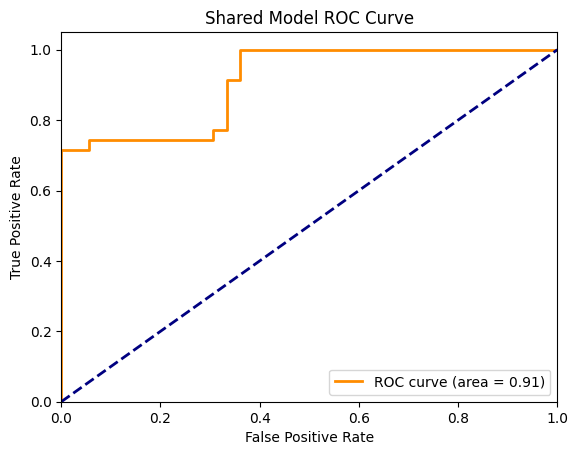

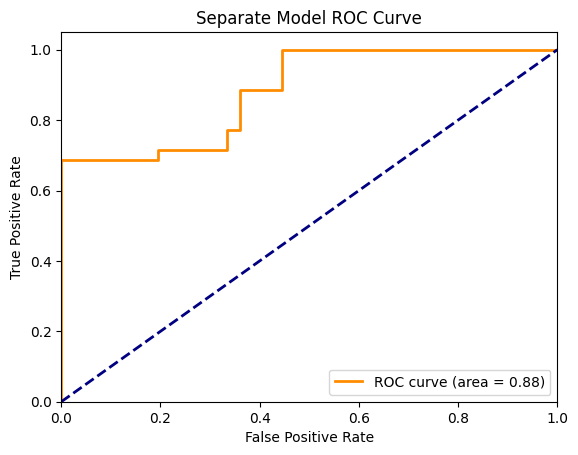

In [36]:
# ROC 커브 시각화
plot_roc_curve(*shared_results['roc_curve'], title='Shared Model ROC Curve')
plot_roc_curve(*separate_results['roc_curve'], title='Separate Model ROC Curve')

In [37]:
# 결과 출력
print("Shared Model - Precision: {:.4f}%, Recall: {:.4f}%, F1-Score: {:.4f}%, Specificity: {:.4f}%, Accuracy: {:.4f}%".format(
    shared_results['precision'] * 100, shared_results['recall']* 100, shared_results['f1_score']* 100, shared_results['specificity']* 100, shared_results['accuracy']*100))

print("Separate Model - Precision: {:.4f}%, Recall: {:.4f}%, F1-Score: {:.4f}%, Specificity: {:.4f}%, Accuracy: {:.4f}%".format(
    separate_results['precision']* 100, separate_results['recall'] * 100, separate_results['f1_score']*100, separate_results['specificity']*100, separate_results['accuracy']*100))


Shared Model - Precision: 100.0000%, Recall: 62.8571%, F1-Score: 77.1930%, Specificity: 100.0000%, Accuracy: 81.6901%
Separate Model - Precision: 100.0000%, Recall: 37.1429%, F1-Score: 54.1667%, Specificity: 100.0000%, Accuracy: 69.0141%


In [38]:
# # 사용자 입력 텍스트 예측
# sample_text = input("텍스트를 입력하세요: ")
# if sample_text.strip():
#     shared_prediction_result = combined_predict(sample_text, shared_model, shared_model, tokenizer, device, prompt_template)
#     separate_prediction_result = separate_predict(sample_text, model_1, model_2, tokenizer, device, prompt_template)

#     # Shared Model 결과 출력
#     original_label_shared = "정상" if shared_prediction_result['original']['predicted_class'] == 0 else "비정상"
#     original_confidence_shared = shared_prediction_result['original']['confidence'] * 100
#     gpt_label_shared = "정상" if shared_prediction_result['gpt_response']['predicted_class'] == 0 else "비정상"
#     gpt_confidence_shared = shared_prediction_result['gpt_response']['confidence'] * 100
#     combined_label_shared = "정상" if shared_prediction_result['combined']['predicted_class'] == 0 else "비정상"
#     combined_confidence_shared = shared_prediction_result['combined']['confidence'] * 100

#     print(f"공유된 모델 - 원본 텍스트 예측: '{sample_text}'는 {original_confidence_shared:.2f}% 확률로 '{original_label_shared}'입니다.")
#     print(f"공유된 모델 - GPT 응답 예측: '{shared_prediction_result['gpt_response']['text']}'는 {gpt_confidence_shared:.2f}% 확률로 '{gpt_label_shared}'입니다.")
#     print(f"공유된 모델 - 종합 예측: {combined_confidence_shared:.2f}% 확률로 '{combined_label_shared}'입니다.")

#     # Separate Model 결과 출력
#     original_label_separate = "정상" if separate_prediction_result['original']['predicted_class'] == 0 else "비정상"
#     original_confidence_separate = separate_prediction_result['original']['confidence'] * 100
#     gpt_label_separate = "정상" if separate_prediction_result['gpt_response']['predicted_class'] == 0 else "비정상"
#     gpt_confidence_separate = separate_prediction_result['gpt_response']['confidence'] * 100
#     combined_label_separate = "정상" if separate_prediction_result['combined']['predicted_class'] == 0 else "비정상"
#     combined_confidence_separate = separate_prediction_result['combined']['confidence'] * 100

#     print(f"분리된 모델 - 원본 텍스트 예측: '{sample_text}'는 {original_confidence_separate:.2f}% 확률로 '{original_label_separate}'입니다.")
#     print(f"분리된 모델 - GPT 응답 예측: '{separate_prediction_result['gpt_response']['text']}'는 {gpt_confidence_separate:.2f}% 확률로 '{gpt_label_separate}'입니다.")
#     print(f"분리된 모델 - 종합 예측: {combined_confidence_separate:.2f}% 확률로 '{combined_label_separate}'입니다.")